In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import models, transforms
from data_generator import show_results
from utils import SquareNet, ImageDataset

## Let's load the data and the model

In [2]:
data = np.load("square_dataset.npz", allow_pickle=True, encoding="latin1")
X = data['X']
Y = data['Y']
dataset = ImageDataset(X,Y)

model = SquareNet()
model.load_state_dict(torch.load('net.pt'))
model.eval()

SquareNet(
  (conv): Sequential(
    (0): Conv2d(2, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=262144, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
  (fc): Linear(in_features=262144, out_features=3, bias=True)
)

## Let's evaluate the results

---- Network evaluation first iteration ----
5.7584887 9.77083 0.42887783
---- Groundtruth ----
5 7 2


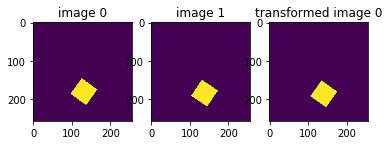

---- Network evaluation second iteration ----
13.03494 15.529298 -1.8861926
---- Groundtruth ----
5 7 2


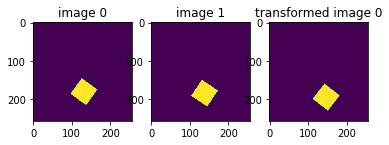

In [7]:
# choose an image in the dataset
i = 987

# let's dig into the dataset
im0 = dataset[i][0]
im1 = dataset[i][1]
obs = dataset[i][2]
x0 = dataset[i][2]['x0']
y0 = dataset[i][2]['y0']
angle0 = dataset[i][2]['angle0']
delta_x, delta_y, delta_angle = dataset[i][2]['transformation']

# we need to concatenate the two images as an input
input_net = torch.cat((im0,im1),0).unsqueeze(0)

print("---- Network evaluation first iteration ----")
results = model(input_net, obs, n_iterations=2)
delta_x_est, delta_y_est, delta_angle_est = results[f'iteration={1}']['transfo_output'][0][:].detach().numpy()
print(delta_x_est, delta_y_est, delta_angle_est)
print("---- Groundtruth ----")
print(delta_x, delta_y, delta_angle)
show_results(im1.numpy()[0,:,:], im0.numpy()[0,:,:], x0, y0, delta_x_est, delta_y_est, delta_angle_est)

print("---- Network evaluation second iteration ----")
delta_x_est, delta_y_est, delta_angle_est = results[f'iteration={2}']['transfo_output'][0][:].detach().numpy()
print(delta_x_est, delta_y_est, delta_angle_est)
print("---- Groundtruth ----")
print(delta_x, delta_y, delta_angle)
show_results(im1.numpy()[0,:,:], im0.numpy()[0,:,:], x0, y0, delta_x_est, delta_y_est, delta_angle_est)